In [16]:
import numpy as np
import pandas as pd
import astropy.constants as c
from astropy.time import Time
import radvel as rv

# For working with Brandt catalog
import astropy as ap
from astropy.table import Table




########### RV Constants #################

m_star_hd191939 = 0.807
m_star_hip97166 = 0.91
m_star = m_star_hd191939

# Simplifying the orbit
tp = 0
e = 0
om = 0

# Trend and curvature values calculated with radvel
hd191939_gamma = [0.114, 0.006, -6e-5, 1.9e-5]
hip97166_gamma = [0.043, 0.033, -2e-4, 1.5e-4]

gamma_dot, gamma_dot_err,  gamma_dotdot, gamma_dotdot_err = hd191939_gamma

timeseries = pd.read_csv('../data/191939_rv.csv', skiprows=14)
rv_baseline = max(Time(list(timeseries.time.values), format='iso').jd) - min(Time(list(timeseries.time.values), format='iso').jd)
max_rv = max(timeseries.mnvel)

# The priors for minimum period and planet mass. min_per is 4xbaseline because we see ~no curvature yet.
min_per = 4*rv_baseline
# Does it make sense to use e = 0 here? Couldn't we set e really high and get a lower mass planet with high semi-amplitude?
min_m = rv.utils.Msini(max_rv, min_per, m_star, e, Msini_units='jupiter')
min_a = rv.utils.semi_major_axis(min_per, (m_star + min_m*(c.M_jup/c.M_sun).value))
# print('Min values: ', min_a, min_m)


########### Astrometry Constants #################
# Choosing the star to analyze
id_hd191939 = 2248126315275354496
id_hip97166 = 2288221003213039488

star_params_hd191939 = [0.807, 58.3]
star_params_hip97166 = [0.91, 68.0]

star_id = id_hd191939
star_params = star_params_hd191939

# System params: Stellar mass and distance in M_Sun, pc => cm
m_star = star_params[0]
d_star = star_params[1]*(c.pc.cgs.value)

# https://www.cosmos.esa.int/web/hipparcos/catalogue-summary lists the dates as 1989.85 and 1993.21
hip_times = Time(['1989-01-01', '1993-01-01'], format='isot').jd + np.array((0.85, 0.21))*365
hip_baseline = hip_times[1]-hip_times[0]
hip_mid = hip_times.mean()

# Gaia hasn't ended yet, but DR2 is listed as spanning 25 Jul. 2014 to 23 May 2016
# https://www.cosmos.esa.int/web/gaia/dr2
gaia_times = Time(['2014-07-25', '2016-05-23'], format='isot').jd
gaia_baseline = gaia_times[1]-gaia_times[0]
gaia_mid = gaia_times.mean()

baseline = gaia_mid - hip_mid

# The proper motions and errors (mas/yr) in the order [Hipparcos, Gaia, HG]
# hdul = ap.io.fits.open('../data/HGCA_vDR2.fits')

hdul = ap.io.fits.open('../data/HGCA_vEDR3.fits')
data_df = Table(hdul[1].data).to_pandas()


hdul.close()

star_line = data_df.query('gaia_source_id == {}'.format(star_id))

ra_array = star_line[['pmra_hip', 'pmra_gaia', 'pmra_hg']].stack().to_list()
ra_err_array = star_line[['pmra_hip_error', 'pmra_gaia_error', 'pmra_hg_error']].stack().to_list()
dec_array = star_line[['pmdec_hip', 'pmdec_gaia', 'pmdec_hg']].stack().to_list()
dec_err_array = star_line[['pmdec_hip_error', 'pmdec_gaia_error', 'pmdec_hg_error']].stack().to_list()

hip_pm = np.sqrt(ra_array[0]**2 + dec_array[0]**2)
hip_pm_err = np.sqrt(  (ra_array[0]/hip_pm)**2*ra_err_array[0]**2  +   (dec_array[0]/hip_pm)**2*dec_err_array[0]**2 )

##########################################################################################################################
gaia_pm = np.sqrt(ra_array[1]**2 + dec_array[1]**2)
gaia_pm_err = np.sqrt(  (ra_array[1]/gaia_pm)**2*ra_err_array[1]**2  +   (dec_array[1]/gaia_pm)**2*dec_err_array[1]**2 )

hg_pm = np.sqrt(ra_array[2]**2 + dec_array[2]**2)
hg_pm_err = np.sqrt(  (ra_array[2]/hg_pm)**2*ra_err_array[0]**2  +   (dec_array[2]/hg_pm)**2*dec_err_array[0]**2 )
##########################################################################################################################


pm_anom_data = np.sqrt((ra_array[2] - ra_array[1])**2 + (dec_array[2] - dec_array[1])**2)
pm_anom_data_err = np.sqrt((ra_array[2] - ra_array[1])**2 * (ra_err_array[2]**2 + ra_err_array[1]**2) + (dec_array[2] - dec_array[1])**2 * (dec_err_array[2]**2 + dec_err_array[1]**2)) / (pm_anom_data)

print(pm_anom_data, pm_anom_data_err)

### Plotting proper motions ###
print(ra_array, dec_array)
print(ra_err_array, dec_err_array)

0.12767382507786398 0.034199052901953214
[151.26492309570312, 150.19378662109375, 150.31161499023438] [-64.6023941040039, -63.98785400390625, -63.938690185546875]
[0.7301717400550842, 0.021173059940338135, 0.026339441537857056] [0.9260193705558777, 0.0231549683958292, 0.028132565319538116]


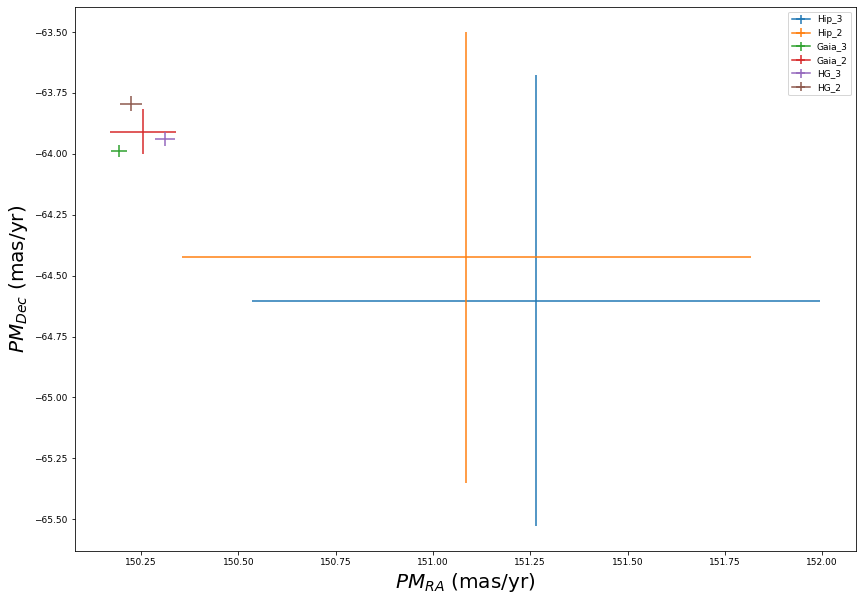

In [20]:
import matplotlib.pyplot as plt
fontsize=20

fig, ax = plt.subplots(figsize=(14,10))
plt.errorbar(ra_array[0], dec_array[0], xerr = ra_err_array[0], yerr = dec_err_array[0], label='Hip_3')
plt.errorbar(ra_array_old[0], dec_array_old[0], xerr = ra_err_array_old[0], yerr = dec_err_array_old[0], label='Hip_2')

plt.errorbar(ra_array[1], dec_array[1], xerr = ra_err_array[1], yerr = dec_err_array[1], label='Gaia_3')
plt.errorbar(ra_array_old[1], dec_array_old[1], xerr = ra_err_array_old[1], yerr = dec_err_array_old[1], label='Gaia_2')

plt.errorbar(ra_array[2], dec_array[2], xerr = ra_err_array[2], yerr = dec_err_array[2], label='HG_3')
plt.errorbar(ra_array_old[2], dec_array_old[2], xerr = ra_err_array_old[2], yerr = dec_err_array_old[2], label='HG_2')

plt.xlabel(r'$PM_{RA}$ (mas/yr)', fontsize=fontsize)
plt.ylabel(r'$PM_{Dec}$ (mas/yr)', fontsize=fontsize)

plt.legend()
plt.show()

In [15]:
ra_array_old = ra_array
ra_err_array_old = ra_err_array

dec_array_old = dec_array
dec_err_array_old = dec_err_array